# Extracting charging signatures


In [1]:
import numpy as np
import pandas as pd
import scipy.signal
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, MeanShift
from sklearn.metrics import silhouette_score, silhouette_samples
# from scipy.ndimage.measurements import center_of_mass

In [2]:
data = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-10houses.csv', 
                header = 0, index_col = 0)
data.index = data.index.map(lambda x: x[:-3])
data.index = pd.to_datetime(data.index)
data = data.astype(np.float64)
data.head()

,dataid,car1,grid
localminute,,,
2017-01-01,26.0,0.005,2.969
2017-01-01,1354.0,0.000,0.266
2017-01-01,114.0,0.000,0.632
2017-01-01,1169.0,0.000,0.469
2017-01-01,379.0,0.005,1.219


In [2]:
week = 7*24*4

In [4]:
ev_signals = pd.DataFrame(index = data[data['dataid'] == data['dataid'][0]].index)
grid_signals = pd.DataFrame(index = data[data['dataid'] == data['dataid'][0]].index)
for i in np.unique(data['dataid']):
    if len(data[data['dataid'] == i]['car1']) == len(ev_signals.index):
        ev_signals[str(i)] = data[data['dataid'] == i]['car1']
        grid_signals[str(i)] = data[data['dataid'] == i]['grid']

ev_signals = ev_signals.resample('15T').mean()
ev_signals.fillna(method='backfill',inplace=True)
ev_signals = ev_signals.T

grid_signals = grid_signals.resample('15T').mean()
grid_signals.fillna(method='backfill',inplace=True)
grid_signals = grid_signals.T

N = ev_signals.index.size
grid_signals.head()

localminute,2017-01-01 00:00:00,2017-01-01 00:15:00,2017-01-01 00:30:00,2017-01-01 00:45:00,2017-01-01 01:00:00,2017-01-01 01:15:00,2017-01-01 01:30:00,2017-01-01 01:45:00,2017-01-01 02:00:00,2017-01-01 02:15:00,...,2017-12-31 15:30:00,2017-12-31 15:45:00,2017-12-31 16:00:00,2017-12-31 16:15:00,2017-12-31 16:30:00,2017-12-31 16:45:00,2017-12-31 17:00:00,2017-12-31 17:15:00,2017-12-31 17:30:00,2017-12-31 17:45:00
26.0,2.759267,1.903067,1.472467,1.020333,1.781867,1.765800,0.565000,0.781933,0.741533,0.610000,...,1.251267,0.676133,0.693533,0.756000,0.985200,3.157000,2.694533,2.480733,2.618133,2.347867
114.0,0.632800,0.571400,0.504000,0.499800,0.562000,0.248333,0.385067,0.382933,0.304600,0.307800,...,1.446467,1.664533,1.555400,2.408933,1.502867,1.591200,1.899867,3.006733,2.609200,2.173133
370.0,0.590667,0.597600,0.589933,1.672000,4.321933,4.314667,3.938533,3.784733,1.566333,0.443600,...,1.239333,0.930467,0.770067,0.825667,0.879067,0.611667,0.600200,0.623933,0.627333,0.630933
379.0,1.210467,1.136200,1.022933,1.301000,1.427867,1.006667,0.757400,0.816733,1.409800,1.272200,...,1.295533,0.835333,1.436267,1.414600,1.072400,1.720333,1.629400,1.763267,1.292000,1.744667
1169.0,0.501333,0.464333,0.770467,0.467000,0.514533,0.460733,0.413667,0.340800,0.399533,0.447867,...,0.684467,0.332000,0.259667,0.666933,0.648467,0.717600,0.587067,0.504467,0.567600,0.687067


## Templates
Since it is reasonable to expect that most households will have a single EV representing the majority of the charging events, it may be useful to extract an average charging signature - or a template - for each charging period for each house. The function make_templates_2 clusters the signatures from a single household, and by doing so may be able to discover multiple such typical signatures. However, when run with the majority_only flag set to True and n_templates=2, the clustering procedure only reduces the cluster containing the most labels - hopefully leaving a noise-cluster behind. A drawback of using KMeans for this operation is of course that KMeans generally assumes similary sized clusters, hence a different clustering method may be better suited. 

In [3]:
def get_signatures(power_series, min_off_duration = 0, min_on_duration = 3):
    
    signatures = []
    current_signal = []
    starts = []
    peak_times = []
    off_duration = 0
    
    for i in range(1,power_series.size):

        if power_series[i] > 1:
            if len(current_signal) == 0:
                if i == 0:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i-1])
            current_signal.append(power_series[i])
            off_duration = 0
        else:
            off_duration += 1
            if off_duration >= min_off_duration and len(current_signal) > min_on_duration:
                if i >= len(current_signal) - 1:
                    current_signal.append(0)
                else:
                    current_signal.append(power_series[i+1])
                signatures.append(current_signal)
                starts.append(power_series.index[i-len(current_signal)])
                peak_times.extend(power_series.index[i-len(current_signal):i])
                current_signal = []
            
    return signatures, starts, pd.to_datetime(peak_times)

def make_templates_2(signatures, significance = 10, n_templates = 2, majority_only = False):
    n = len(signatures)
    signatures_by_length = []
    templates = []
    if n == 0:
        return []
    
    #create array where the ith element is an array containing all the length i signatures.
    for i in range(np.max([len(s) for s in signatures])):
        length_n_signatures = [s for s in signatures if len(s) == i]
        
        if len(length_n_signatures) > significance: #significance criterium
            signatures_by_length.append(length_n_signatures)
        
    kmeans = KMeans(n_clusters=n_templates)

    for length_n_signatures in signatures_by_length:
        cluster_indices = kmeans.fit_predict(length_n_signatures)
        length_n_templates = []
        
        if majority_only:
            majority_cluster = np.argmax(np.bincount(cluster_indices))
            cluster = [length_n_signatures[j] for j in range(len(length_n_signatures)) if cluster_indices[j] == majority_cluster]
            template = np.array(np.sum(cluster, axis=0))
            template /= len(cluster)
            length_n_templates.append(template)
        else:
            for i in range(n_templates):
                cluster = [length_n_signatures[j] for j in range(len(length_n_signatures)) if cluster_indices[j] == i]
                template = np.array(np.sum(cluster, axis=0))
                template /= len(cluster)
                length_n_templates.append(template)

        templates.extend(length_n_templates)
    
    return templates

In [4]:
def sort_by_length(sequences, keep_length = 0):
    sorted_sequences = []
    
    for n in range(max([len(s) for s in sequences])):
        length_n_sequences = np.array([s for s in sequences if len(s) == n])
        if len(length_n_sequences) > keep_length:
            sorted_sequences.append(length_n_sequences)
        #print("There are {} sequences of length {}".format(len(length_n_sequences),n))
        
    return sorted_sequences

def silhouette_sample_score(scores):
    scores = np.array(scores)
    cluster_scores = np.zeros((scores.shape[1],scores.shape[0]))
    
    for i in range(len(scores)):
        for j in range(len(scores[i])):
            cluster_scores[j,i] += (scores[i,j][scores[i,j] > np.mean(scores[i,j])]).size / scores[i,j].size
    
    return np.mean(cluster_scores, axis=1)

In [7]:
nl = 1
sctt = np.zeros(len(silhouette_sample_scores2[0]))

for nl in range(len(silhouette_sample_scores2)):
    sct = []
    for i in range(len(silhouette_sample_scores2[nl])):
        sc = (silhouette_sample_scores2[nl][i][silhouette_sample_scores2[nl][i] > np.mean(silhouette_sample_scores2[nl][i])]).size / len(silhouette_sample_scores2[nl][i])
        sct.append(sc)
    
    sctt+=sct

    plt.plot(n_clusters_s2, sct)

print(sctt/len(silhouette_sample_scores2))
plt.legend(["Length {} signals".format(len(s[0])) for s in signatures_sorted2],bbox_to_anchor=(1, 1))
plt.plot(n_clusters_s2,sctt/len(silhouette_sample_scores2), color='black', marker='o')
plt.show()

NameError: name 'silhouette_sample_scores2' is not defined

In [8]:
n_templates = 2
templates = []
signatures = []

for i in range(N):
    s, _, _ = get_signatures(ev_signals.iloc[i])
    t = make_templates_2(s, n_templates=n_templates, majority_only=True)
    signatures.extend(s)
    templates.extend(t)


In [9]:
templates_sorted = sort_by_length(templates, keep_length = 3)
signatures_sorted = sort_by_length(signatures, keep_length = 20)
template_cluster_scores = [[] for _ in range(len(templates_sorted))]
signature_cluster_scores = [[] for _ in range(len(signatures_sorted))]
silhouette_sample_scores = [[] for _ in range(len(signatures_sorted))]

n_clusters = range(2,min([len(t) for t in templates_sorted]))
n_clusters_s = range(2,min([len(s) for s in signatures_sorted]))

for i in n_clusters:
    for j in range(len(templates_sorted)):
        template_clustering = KMeans(n_clusters=i)
        template_clustering.fit(templates_sorted[j])
        template_cluster_scores[j].append(silhouette_score(templates_sorted[j],template_clustering.labels_))

for i in n_clusters_s:
    for j in range(len(signatures_sorted)):
        signature_clustering = KMeans(n_clusters=i)
        signature_clustering.fit(signatures_sorted[j])
        signature_cluster_scores[j].append(silhouette_score(signatures_sorted[j],signature_clustering.labels_))
        silhouette_sample_scores[j].append(silhouette_samples(signatures_sorted[j],signature_clustering.labels_))

                

In [10]:
best_n_clusters = n_clusters[int(np.argmax(np.mean(template_cluster_scores,axis=0)))]
best_n_clusters_s = n_clusters_s[int(np.argmax(np.mean(signature_cluster_scores,axis=0)))]

print("Best template clustering: {}\nBest signature clustering: {}".format(best_n_clusters, best_n_clusters_s))

Best template clustering: 2
Best signature clustering: 2


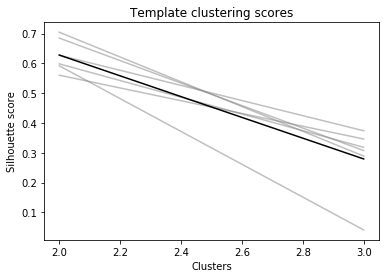

NameError: name 'signature_cluster_scores2' is not defined

In [11]:
for length_n_score in template_cluster_scores:
    plt.plot(n_clusters, length_n_score, alpha = 0.5, color = 'grey')
plt.plot(n_clusters,np.mean(template_cluster_scores,axis=0), color = 'black')

plt.title("Template clustering scores")
#plt.legend(["Length {} signals".format(len(templates_sorted[i][0])) for i in range(len(templates_sorted))],bbox_to_anchor=(1, 1))
plt.xlabel("Clusters")
plt.ylabel("Silhouette score")
plt.show()

for length_n_score in signature_cluster_scores:
    plt.plot(n_clusters_s, length_n_score, alpha = 0.5, color = 'grey')
plt.plot(n_clusters_s,np.mean(signature_cluster_scores,axis=0), color = 'black', marker = 'o', markersize = 5)
plt.axhline(np.mean(signature_cluster_scores2), ls='--', color='red')
plt.title("Signal clustering scores")
#plt.legend(["Length {} signals".format(len(signatures_sorted[i][0])) for i in range(len(signatures_sorted))],bbox_to_anchor=(1, 1))
plt.xlabel("Clusters")
plt.ylabel("Silhouette score")
plt.show()

plt.plot(n_clusters_s, silhouette_sample_score(silhouette_sample_scores)*100, color='black', marker='o')
plt.title("Silhouette sample score")
plt.ylabel("% of samples above average")
plt.xlabel("Number of clusters")
plt.show()

### Silhouette score
The silhouette score is a clustering metric, and measures the relationship between the intra-cluster distance and the distance to the nearest neighboring cluster for each data point. Specifically the silhouette score is defined as $s[i] = \frac{b[i] - a[i]}{max(b[i],a[i])}$, where $b[i]$ is the average distance from data point $i$ to every data point in the closest cluster which $i$ does not belong to, and $a[i]$ is the average distance from $i$ to every data point in the same cluster as $i$. Note that for a single data point, this means that a score close to 1 means it is perfectly clustered, while a negative score means that it is incorrectly clustered.


# Using more data (where the good stuff begins)
The following explores the signals from a total of 43 households.

In [5]:
ev_signals_2 = pd.read_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\dataport-ev-signals.csv', 
                header = 0, index_col = 0)
ev_signals_2.shape

(43, 35016)

In [13]:
#ev_signals_2 = more_ev_signals.append(ev_signals)

In [6]:
more_signatures = []
more_templates = []
N2 = len(ev_signals_2.index)

for i in range(N2):
    s, _, _ = get_signatures(ev_signals_2.iloc[i])
    more_signatures.extend(s)
    #t = make_templates_2(s, n_templates=n_templates, majority_only=True)
    #more_templates.extend(t)

In [16]:
signatures_sorted2 = sort_by_length(more_signatures, keep_length = 100)
signatures_sorted2 = signatures_sorted2[3:] #drop the three first
signature_cluster_scores2 = [[] for _ in range(len(signatures_sorted2))]
silhouette_sample_scores2 = [[] for _ in range(len(signatures_sorted2))]
n_clusters_s2 = range(2,min(N2,min([len(s) for s in signatures_sorted2])))

cluster_labels = [[] for _ in range(len(signatures_sorted2))]

# templates_sorted2 = sort_by_length(more_templates, keep_length = 6)
# template_cluster_scores2 = [[] for _ in range(len(templates_sorted2))]
# template_sample_scores2 = [[] for _ in range(len(templates_sorted2))]
# n_clusters_t2 = range(2,min(N2,min([len(t) for t in templates_sorted2])))

print("Clustering for {} different lengths".format(len(signatures_sorted2)))

for i in n_clusters_s2:
    for j in range(len(signatures_sorted2)):
        signature_clustering = KMeans(n_clusters=i)
        signature_clustering.fit(signatures_sorted2[j])
        signature_cluster_scores2[j].append(silhouette_score(signatures_sorted2[j],signature_clustering.labels_))
        silhouette_sample_scores2[j].append(silhouette_samples(signatures_sorted2[j],signature_clustering.labels_))
        cluster_labels[j].append(signature_clustering.labels_)
        
# for i in n_clusters_t2:
#     for j in range(len(templates_sorted2)):
#         template_clustering = KMeans(n_clusters=i)
#         template_clustering.fit(templates_sorted2[j])
#         template_cluster_scores2[j].append(silhouette_score(templates_sorted2[j],template_clustering.labels_))
#         template_sample_scores2[j].append(silhouette_samples(templates_sorted2[j],template_clustering.labels_))


Clustering for 11 different lengths


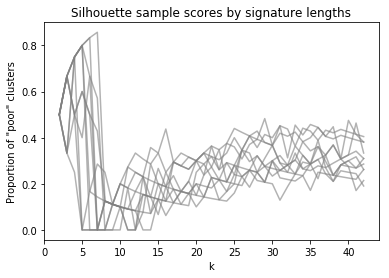

In [8]:
# silhouette_sample_scores2[<signature_lengths>][<n_clusters>][<n_samples of length>]
#j = np.random.randint(0,len(signatures_sorted2))
clustering_scores = []
for j in range(len(signatures_sorted2)):
    clustering_score = []
    clustering_max = []
    clustering_mean = []

    for i in n_clusters_s2:
        signature_clustering = KMeans(n_clusters=i)
        signature_clustering.fit(signatures_sorted2[j])
        ss = silhouette_samples(signatures_sorted2[j],signature_clustering.labels_)
        cs = []
        for l in np.unique(signature_clustering.labels_):
            cs.append(np.max(ss[np.where(signature_clustering.labels_ == l)],axis=0))
        clustering_max.append(cs)
        clustering_mean.append(np.mean(ss))

    for i in range(len(clustering_max)):
        clustering_score.append(np.size(np.where(clustering_max[i] < clustering_mean[i]))/np.size(clustering_max[i]))

    clustering_scores.append(clustering_score)
    handle2 = plt.plot(n_clusters_s2, clustering_score, color='grey', alpha=0.6)

plt.title("Silhouette sample scores by signature lengths")
plt.xlabel("k")
plt.ylabel("Proportion of \"poor\" clusters")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\silhouette_sample.png')
plt.show()

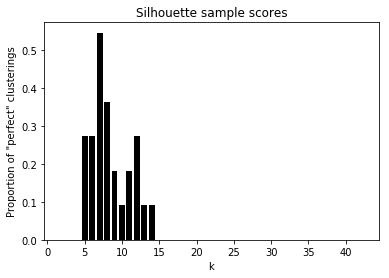

In [10]:
zero_clusters = np.zeros(len(clustering_scores[0]))

for s in clustering_scores:
    zero_clusters[np.where(np.array(s) == 0.0)] += 1

plt.bar(n_clusters_s2, zero_clusters/len(clustering_scores), color='black')
plt.title("Silhouette sample scores")
plt.xlabel("k")
plt.ylabel("Proportion of \"perfect\" clusterings")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\silhouette_sample_proportion.svg')
plt.show()

## Choosing k
Finding the natural number of clusters in a data set is not an easy task. Humans excel at this, and are therefore prone to underestimating its difficulty. First, a clustering metric must be introduced, in this case the silhouette score. Second, some choices concerning the structure of the data must be made.<br>

We are concerned with finding typical charging signatures, and doing so we must try to minimize the similarity of these templates to the original signatures while also limiting the number of templates in order to make the final pattern matching algorithm tractable. Luckily we can control the number of templates quite easily, and having chosen a minimum number of signatures for a given length to be 20, it makes sense to choose this as the maximum number of templates as well. Well within what we know is a reasonable range of templates, we are then free to choose the highest $k$ which satisfies our silhouette score threshold. We choose this threshold to be the average across all $k$ and thus choose $k' = max(k_{large})\forall k_{large} \text{ such that }silhouette(k_{large}) > silhouette(k)_{avg}$.

See http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

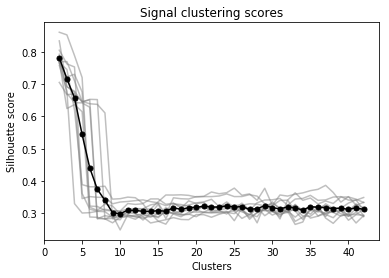

In [65]:

### Signal score plot ###
for length_n_score in signature_cluster_scores2:
    plt.plot(n_clusters_s2, length_n_score, alpha = 0.5, color = 'grey')
plt.plot(n_clusters_s2,np.mean(signature_cluster_scores2,axis=0), color = 'black', marker = 'o', markersize = 5)

plt.title("Signal clustering scores")
#plt.legend(["Length {} signals".format(len(signatures_sorted[i][0])) for i in range(len(signatures_sorted))],bbox_to_anchor=(1, 1))
plt.xlabel("Clusters")
plt.ylabel("Silhouette score")
#plt.axhline(np.mean(signature_cluster_scores2), ls='--', color='red')
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\Signature_extraction\\silhouette_score.pdf')
plt.show()

# ### Template score plot ###
# for length_n_score in template_cluster_scores2:
#     plt.plot(n_clusters_t2, length_n_score, alpha = 0.5, color = 'grey')
# plt.plot(n_clusters_t2,np.mean(template_cluster_scores2,axis=0), color = 'black', marker = 'o', markersize = 5)

# plt.title("Template clustering scores")
# #plt.legend(["Length {} signals".format(len(signatures_sorted[i][0])) for i in range(len(signatures_sorted))],bbox_to_anchor=(1, 1))
# plt.xlabel("Clusters")
# plt.ylabel("Silhouette score")
# plt.axhline(np.mean(template_cluster_scores2), ls='--', color='red')
# plt.show()

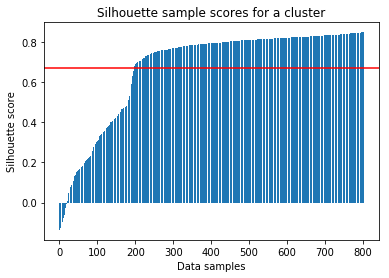

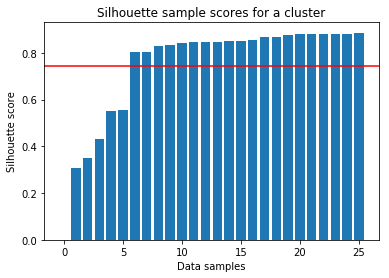

In [19]:
plt.bar(range(len(silhouette_sample_scores2[0][1])),np.sort(silhouette_sample_scores2[0][1]))
plt.axhline(np.mean(silhouette_sample_scores2[0][1]), color='red')
plt.title("Silhouette sample scores for a cluster")
plt.xlabel("Data samples")
plt.ylabel("Silhouette score")
plt.show()

plt.bar(range(len(template_sample_scores2[0][1])),np.sort(template_sample_scores2[0][1]))
plt.axhline(np.mean(template_sample_scores2[0][1]), color='red')
plt.title("Silhouette sample scores for a cluster")
plt.xlabel("Data samples")
plt.ylabel("Silhouette score")
plt.show()

**Above:** It is possible to analyse the fit of a clustering by looking at the number of data points with an above-average silhouette score. A good clustering should look like the one above, with many points above average and some noise. A better way is to examine how this noise/high-score distribution is within each cluster.<br>
The "signal sample score"-graphs **below** represent this approach: The average number of samples above the average silhouette score for each cluster. 

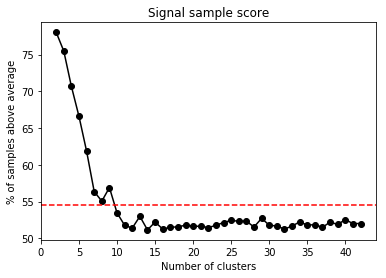

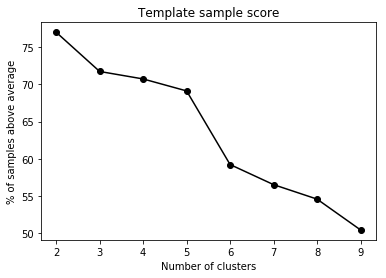

In [20]:
plt.plot(n_clusters_s2, silhouette_sample_score(silhouette_sample_scores2)*100, color='black', marker='o')
plt.axhline(np.mean(silhouette_sample_score(silhouette_sample_scores2)*100), color='red', linestyle='--')
plt.title("Signal sample score")
plt.ylabel("% of samples above average")
plt.xlabel("Number of clusters")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\silhouette_avg_sample_score.png')
plt.show()

plt.plot(n_clusters_t2, silhouette_sample_score(template_sample_scores2)*100, color='black', marker='o')
plt.title("Template sample score")
plt.ylabel("% of samples above average")
plt.xlabel("Number of clusters")
plt.show()

In [18]:
best_n_clusters_s2 = 0
mean_scores = np.mean(signature_cluster_scores2,axis=0)

for i in range(mean_scores.size):
    if mean_scores[i] < np.mean(mean_scores):
        break
    best_n_clusters_s2 = n_clusters_s2[i]

# best_n_clusters_t2 = 0
# mean_scores_t = np.mean(template_cluster_scores2,axis=0)

# for i in range(mean_scores_t.size):
#     if mean_scores_t[i] < np.mean(mean_scores_t):
#         break
#     best_n_clusters_t2 = n_clusters_t2[i]
    
print("Best signature clustering: {}".format(best_n_clusters_s2))
# print("Best template clustering: {}".format(best_n_clusters_t2))

Best signature clustering: 7


### Charging signatures by duration

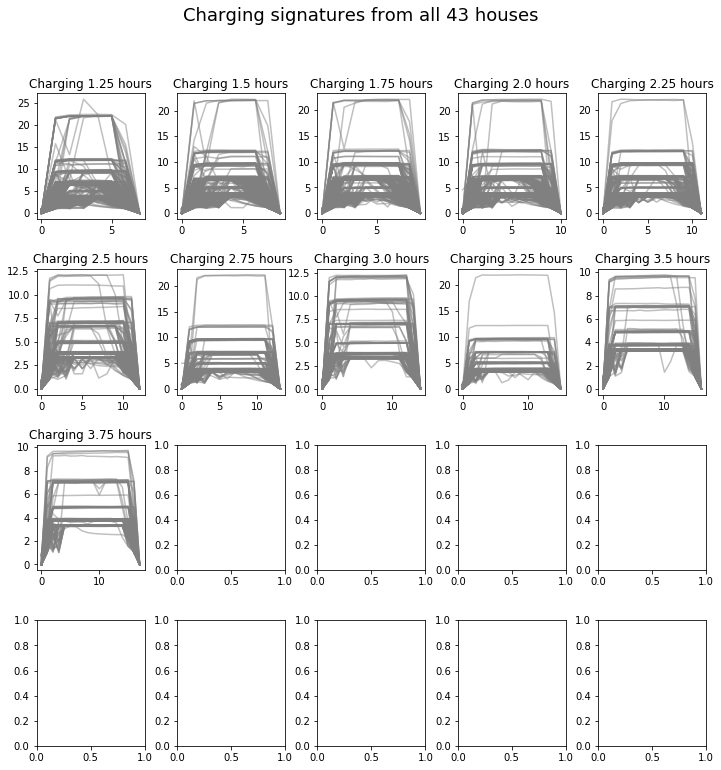

In [22]:
fig, axarr = plt.subplots(4,5,sharex=False)
plt.subplots_adjust(hspace=0.4,wspace=0.3)
fig.set_size_inches(12,12)

for i in range(len(signatures_sorted2)):
    for j in range(len(signatures_sorted2[i])):
        axarr[int(np.floor(i/5)),int(i%5)].plot(signatures_sorted2[i][j],color='grey',alpha=0.5)
        axarr[int(np.floor(i/5)),int(i%5)].set_title("Charging "+ str((i+5)/4) + " hours")

fig.suptitle("Charging signatures from all 43 houses", fontsize=18)
# fig.set_xlabel("kW")
# fig.ylabel("Timesteps (15 minutes)")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\all_charging_signatures.png')

plt.show()

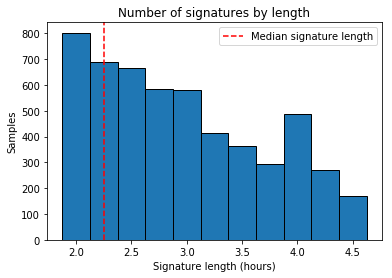

In [23]:
plt.bar([len(s[0])/4 for s in signatures_sorted2], [len(s) for s in signatures_sorted2], edgecolor = 'black', width = 0.25)
med = plt.axvline(np.median([len(s)/4 for s in more_signatures]), color='red', ls='--')
plt.legend(handles=[med], labels=["Median signature length"], bbox_to_anchor=(1,1))
plt.title("Number of signatures by length")
plt.xlabel("Signature length (hours)")
plt.ylabel("Samples")
plt.show()

### Charging signature templates by duration

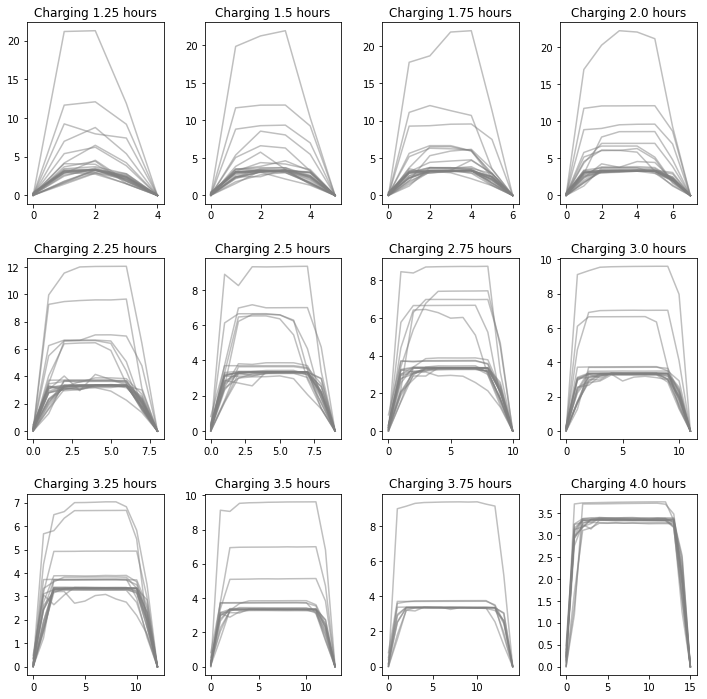

In [24]:
fig, axarr = plt.subplots(3,4,sharex=False)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
fig.set_size_inches(12,12)

for i in range(len(templates_sorted2)):
    for j in range(len(templates_sorted2[i])):
        axarr[int(np.floor(i/4)),int(i%4)].plot(templates_sorted2[i][j],color='grey',alpha=0.5)
        axarr[int(np.floor(i/4)),int(i%4)].set_title("Charging "+ str((i+5)/4) + " hours")

plt.show()

In [19]:
clusters = [[] for _ in range(best_n_clusters_t2)]

j = np.random.randint(len(templates_sorted))

best_clustering = KMeans(n_clusters=best_n_clusters_t2)
labels = best_clustering.fit_predict(templates_sorted2[j])

for k in range(best_n_clusters_t2):
    clusters[k].extend([templates_sorted2[j][i] for i in range(len(templates_sorted2[j])) if labels[i] == k])

markers = [',', '+', '.', 'o', '*', '<', '>', '1', '2', '3', '4'] 
cmap = ['blue','red','orange','green','black','brown','pink','cyan']
names = ["Cluster {}".format(i) for i in range(best_n_clusters_t2)]
handles = [None for _ in range(best_n_clusters_t2)]

for i in range(best_n_clusters_t2):
    for k in range(len(clusters[i])):
        handles[i], = plt.plot(clusters[i][k], color=cmap[i], label = labels[i], marker=markers[i])
        
plt.xlabel("Time (hours)")
plt.ylabel("Power (kWh)")
plt.title("Clustered charging templates of length {} hours".format((len(signatures_sorted2[j][0])-1)/4))
plt.legend(handles=handles,labels=names, bbox_to_anchor=(1, 1))
plt.show()

NameError: name 'best_n_clusters_t2' is not defined

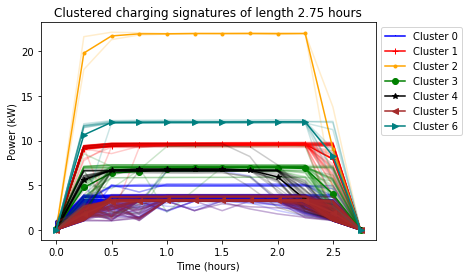

In [21]:
clusters = [[] for _ in range(best_n_clusters_s2)]

j = 4#np.random.randint(len(signatures_sorted2))

best_clustering = KMeans(n_clusters=best_n_clusters_s2)
labels = best_clustering.fit_predict(signatures_sorted2[j])

for k in range(best_n_clusters_s2):
    clusters[k].extend([signatures_sorted2[j][i] for i in range(len(signatures_sorted2[j])) if labels[i] == k])

markers = [',', '+', '.', 'o', '*', '<', '>', '1', '2', '3', '4'] 
cmap = ['blue','red','orange','green','black','brown','teal','pink','cyan','yellow']
names = ["Cluster {}".format(i) for i in range(best_n_clusters_s2)]
handles = [None for _ in range(best_n_clusters_s2)]

for i in range(best_n_clusters_s2):
    for k in range(len(clusters[i])):
        handles[i], = plt.plot(np.arange(len(clusters[i][k]))/4,clusters[i][k], color=cmap[i] ,alpha=0.2)
    handles[i], = plt.plot(np.arange(len(clusters[i][0]))/4,np.mean(clusters[i],axis=0), color=cmap[i], label = labels[i], marker=markers[i])
        
plt.xlabel("Time (hours)")
plt.ylabel("Power (kW)")
plt.title("Clustered charging signatures of length {} hours".format((len(signatures_sorted2[j][0])-1)/4))
lgd = plt.legend(handles=handles,labels=names, bbox_to_anchor=(1, 1))
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\sample_clustering.pdf', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

## Moving forward
The idea is that if a valid clustering containing one cluster for each charging signature type can be obtained, then the clusters from this clustering can be used to form filters unique to each charging signature. The issue is discovering the correct number of clusters without knowing the number of different charging signatures which appear in the data. A close look at the aggregate graphs reveal three distinct signatures, but confidently discovering this number in the general case may be impossible. <br>
For now it seems that a good idea may be discovering the "elbow" of both the silhouette score (average difference between cluster density and distance to neighboring cluster), and the silhouette sample score (number of samples above the average silhouette score). The issue is that neither method yields an unambiguous k.<br>


In [22]:
signatures_per_house = []

for i in range(N2):
    s, _, _ = get_signatures(ev_signals_2.iloc[i])
    if len(s) > 0:
        signatures_per_house.append(s)

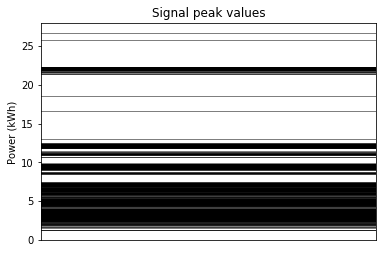

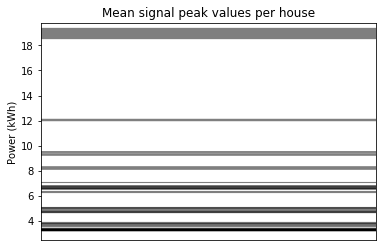

In [23]:
n_signature_houses = len(signatures_per_house)

house_mean_peaks = np.zeros(n_signature_houses)
house_peaks_std = np.zeros(n_signature_houses)
for i in range(n_signature_houses):
    house_mean_peak = []
    for j in range(len(signatures_per_house[i])):
        house_mean_peak.append(max(signatures_per_house[i][j]))
        plt.axhline(max(signatures_per_house[i][j]), color='black', alpha=0.5, linewidth=1+house_peaks_std[i]*2)
    house_mean_peaks[i] = np.mean(house_mean_peak)
    house_peaks_std[i] = np.std(house_mean_peak)

plt.title("Signal peak values")
plt.ylabel("Power (kWh)")
plt.xticks([])
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\charging_signatures_by_max_individual.png')
plt.show()
                    
# plt.hist(house_mean_peaks, bins=20)
# plt.title("Distribution of mean signal peak values")
# plt.ylabel("Samples")
# plt.xlabel("Power (kWh)")
# plt.show()


for i in range(len(house_mean_peaks)):
    plt.axhline(house_mean_peaks[i], color='black', alpha=0.5, linewidth=1+house_peaks_std[i]*2)
plt.title("Mean signal peak values per house")
plt.ylabel("Power (kWh)")
plt.xticks([])
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\charging_signatures_by_max.png')
plt.show()

This makes it seem as if there are 7 different clusters of charging patterns.

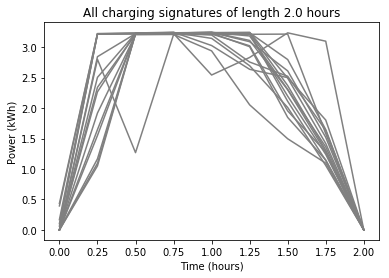

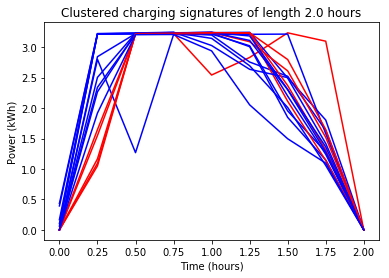

In [29]:
s_2368,_ ,_ = get_signatures(ev_signals_2.loc[2638.0])
sorted2368 = sort_by_length(s_2368, keep_length = 10)

dice = np.random.randint(len(sorted2368))
cl = KMeans(n_clusters=2)
clfit = cl.fit_predict(sorted2368[dice])
for s in sorted2368[dice]:
    plt.plot(np.arange(len(sorted2368[dice][0]))/4, s, color='grey')
plt.title("All charging signatures of length {} hours".format((len(sorted2368[dice][0])-1)/4))
plt.xlabel("Time (hours)")
plt.ylabel("Power (kWh)")
plt.show()

for i in range(len(clfit)):
    plt.plot(np.arange(len(sorted2368[dice][0]))/4, sorted2368[dice][i],color=cmap[clfit[i]])
plt.title("Clustered charging signatures of length {} hours".format((len(sorted2368[dice][0])-1)/4))
plt.xlabel("Time (hours)")
plt.ylabel("Power (kWh)")
plt.show()

**Next:** ~~Examine the intra-cluster variance~~ and ~~understand the k-picking algorithm w/silhouette score.~~ 

### Intra-cluster variance:

In [24]:

clusters = [[[] for _ in range(best_n_clusters_s2)] for _ in range(len(signatures_sorted2))]


for j in range(len(signatures_sorted2)):
    best_clustering = KMeans(n_clusters=best_n_clusters_s2)
    labels = best_clustering.fit_predict(signatures_sorted2[j])
    
    for k in range(best_n_clusters_s2):
        clusters[j][k].extend([signatures_sorted2[j][i] for i in range(len(signatures_sorted2[j])) if labels[i] == k])


In [25]:
cluster_std = np.zeros(np.shape(clusters))

for n in range(len(clusters)):
    for j in range(len(clusters[n])):
        cluster_std[n][j] += np.std(clusters[n][j])
        


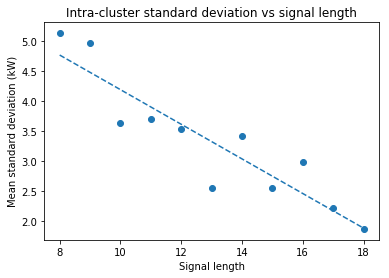

In [26]:
#plt.plot([len(s[0]) for s in signatures_sorted2],np.mean(cluster_std,axis=1), color='black', marker='o')
from scipy.stats import linregress

plt.scatter([len(s[0]) for s in signatures_sorted2],np.mean(cluster_std, axis=1))
lr = linregress([len(s[0]) for s in signatures_sorted2], np.mean(cluster_std, axis=1))
plt.plot([len(s[0]) for s in signatures_sorted2], np.array([len(s[0]) for s in signatures_sorted2])*lr.slope + lr.intercept, '--')
plt.title("Intra-cluster standard deviation vs signal length")
plt.xlabel("Signal length")
plt.ylabel("Mean standard deviation (kW)")
plt.show()

In [27]:
cluster_means = [[None for j in range(best_n_clusters_s2)] for n in range(len(signatures_sorted2))]
cluster_max = [[None for j in range(best_n_clusters_s2)] for n in range(len(signatures_sorted2))]

for n in range(len(signatures_sorted2)):
    for j in range(best_n_clusters_s2):
        cluster_means[n][j] = np.mean(clusters[n][j], axis=0)
        cluster_max[n][j] = np.max(clusters[n][j])


### Examining variance
In the following plots the lines represent the mean for each cluster, while the shaded areas correspond to 1 standard deviation. While not particularly helpful, the plots seem to reveal a tendency towards a high variance for the high-power clusters and the clusters for longer signals.

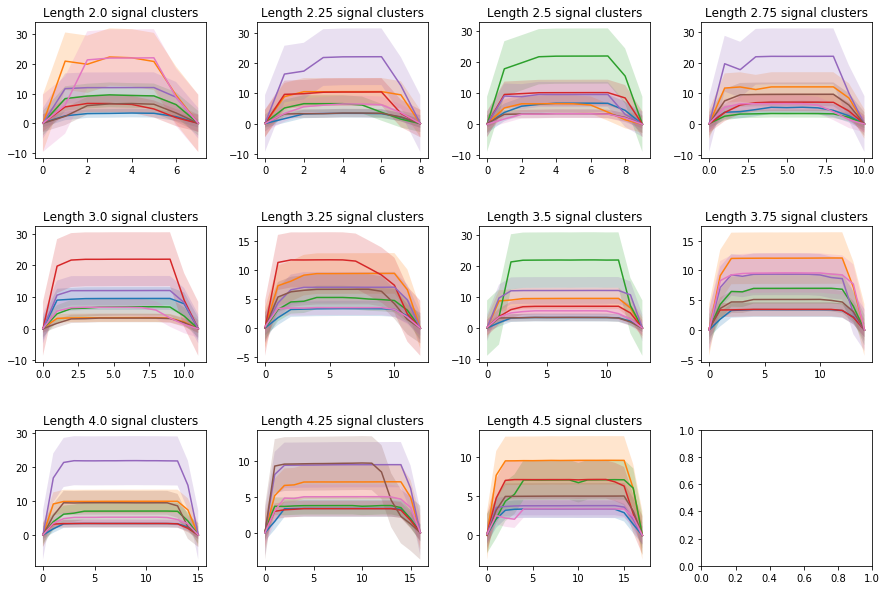

In [34]:
fig, axarr = plt.subplots(3,4,sharex=False)
plt.subplots_adjust(hspace=0.5,wspace=0.3)
fig.set_size_inches(15,10)


for n in range(len(signatures_sorted2)):
    for j in range(best_n_clusters_s2):
        axarr[int(np.floor(n/4)),int(n%4)].set_title("Length {} signal clusters".format(len(signatures_sorted2[n][0])/4))
        axarr[int(np.floor(n/4)),int(n%4)].fill_between(range(len(signatures_sorted2[n][0])),cluster_means[n][j] - cluster_std[n][j], cluster_means[n][j] + cluster_std[n][j], alpha = 0.2)
    for j in range(best_n_clusters_s2):
        axarr[int(np.floor(n/4)),int(n%4)].plot(cluster_means[n][j], )
plt.show()

### A closer look at the signals of duration 4 hrs 15 minutes 

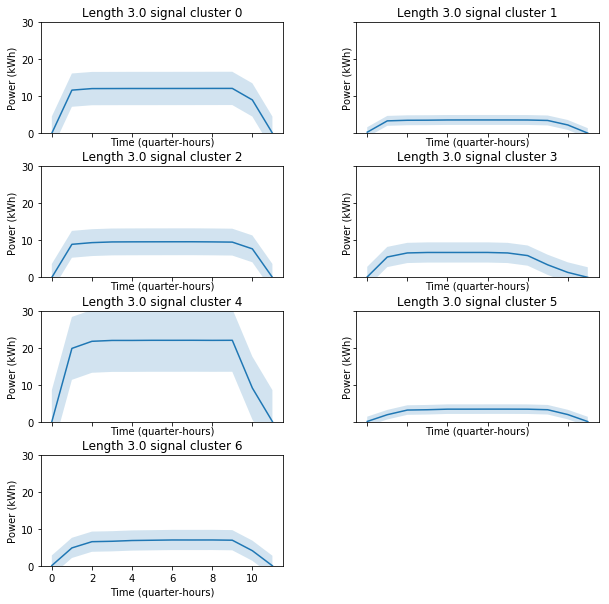

In [86]:
fig, axarr = plt.subplots(4,2,sharex=True, sharey=True)
plt.subplots_adjust(hspace=0.3,wspace=0.3)
fig.set_size_inches(10,10)
plt.ylim(0,30)
ratios = []

n = 4
for j in range(best_n_clusters_s2):
    axarr[int(np.floor(j/2)),int(j%2)].set_title("Length {} signal cluster {}".format(len(signatures_sorted2[n][0])/4,j))
    axarr[int(np.floor(j/2)),int(j%2)].fill_between(range(len(signatures_sorted2[n][0])),cluster_means[n][j] - cluster_std[n][j], cluster_means[n][j] + cluster_std[n][j], alpha = 0.2)
    axarr[int(np.floor(j/2)),int(j%2)].plot(cluster_means[n][j])
    axarr[int(np.floor(j/2)),int(j%2)].set_xlabel("Time (quarter-hours)")
    axarr[int(np.floor(j/2)),int(j%2)].set_ylabel("Power (kWh)")

fig.delaxes(axarr.flatten()[best_n_clusters_s2])
# for i in range((best_n_clusters_s2 % 3*3) - 1):
#     fig.delaxes(axarr.flatten()[best_n_clusters_s2 + i])
    
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\Signature_extraction\\sample_templates.pdf')
plt.show()

for n in range(len(signatures_sorted2)):
    ratios.append([cluster_std[n][j] / np.mean(cluster_means[n][j]) for j in range(best_n_clusters_s2)])


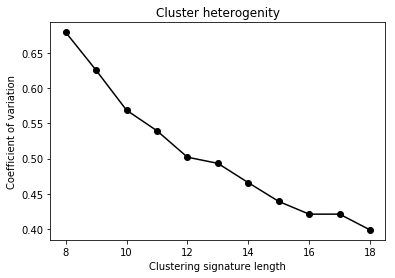

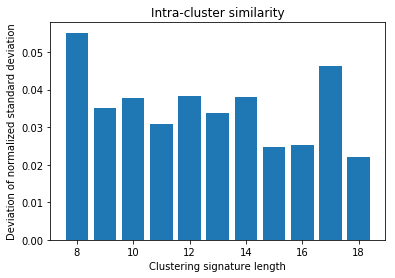

In [78]:
plt.plot([len(s[0]) for s in signatures_sorted2],np.mean(ratios,axis=1), marker='o', color='black')
plt.title("Cluster heterogenity")
plt.xlabel("Clustering signature length")
plt.ylabel("Coefficient of variation")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\cluster_heterogenity.svg')
plt.show()

plt.bar([len(s[0]) for s in signatures_sorted2], np.std(ratios,axis=1))
plt.title("Intra-cluster similarity")
plt.xlabel("Clustering signature length")
plt.ylabel("Deviation of normalized standard deviation")
plt.show()

#### On the variance of the clusters
The standard deviation to mean ratio seems to be fairly constant for each signature length (>0.02). The intra-cluster similarity increases with increasing signature lengths. This implies maybe some of the shorter-length filters can be dropped, while clusters within a signature length should not be. This can be explored further by examining the number signals above a certain length in each house (**below**). 

Shortest maximum charging length: House 36 - 2.5 hours
Median: 5.25 hours
Longest minimum charging length: House 0 - 1.25 hours
Smallest number of signature samples: House 17 - 29 samples
Median: 224.0 samples


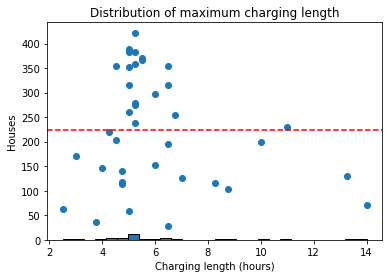

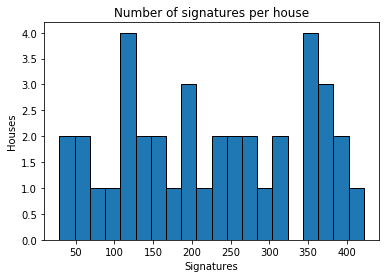

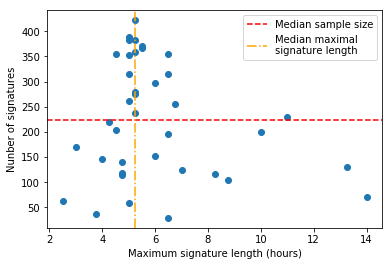

In [54]:
house_signature_lengths = []

for i in range(len(signatures_per_house)):
    signature_lengths = []
    for j in range(len(signatures_per_house[i])):
        signature_lengths.append(len(signatures_per_house[i][j]))
    house_signature_lengths.append(np.bincount(signature_lengths))
    
print("Shortest maximum charging length: House {} - {} hours\nMedian: {} hours".format(np.argmin([len(s) for s in house_signature_lengths]),
                                                                                       np.min([len(s) for s in house_signature_lengths])/4, 
                                                                                       np.median([len(s) for s in house_signature_lengths])/4))
print("Longest minimum charging length: House {} - {} hours".format(np.argmin([len(s) - len(np.trim_zeros(s)) for s in house_signature_lengths]),
                                                                    np.min([len(s) - len(np.trim_zeros(s)) for s in house_signature_lengths])/4))
print("Smallest number of signature samples: House {} - {} samples\nMedian: {} samples".format(np.argmin([np.sum(s) for s in house_signature_lengths]),
                                                                                            np.min([np.sum(s) for s in house_signature_lengths]),
                                                                                            np.median([np.sum(s) for s in house_signature_lengths])))

plt.hist([len(s)/4 for s in house_signature_lengths], bins=28, edgecolor='black')
plt.title("Distribution of maximum charging length")
plt.xlabel("Charging length (hours)")
plt.ylabel("Houses")
plt.show()

plt.hist([np.sum(s) for s in house_signature_lengths], bins=20, edgecolor='black')
plt.title("Number of signatures per house")
plt.xlabel("Signatures")
plt.ylabel("Houses")
plt.show()

#plt.bar(np.arange(len(signatures_per_house)), [np.sum(s) for s in house_signature_lengths], edgecolor='black')
#plt.bar(np.arange(len(signatures_per_house)), [len(s) for s in house_signature_lengths])

plt.scatter([len(s)/4 for s in house_signature_lengths], [np.sum(s) for s in house_signature_lengths])

plt.axhline(np.median([np.sum(s) for s in house_signature_lengths]), ls='--', color='red', alpha=1, label="Median sample size")
#plt.axhline(np.percentile([np.sum(s) for s in house_signature_lengths],25), ls=':', color='red', alpha=0.8, label="Quartiles")
#plt.axhline(np.percentile([np.sum(s) for s in house_signature_lengths],75), ls=':', color='red', alpha=0.8)

plt.axvline(np.median([len(s)/4 for s in house_signature_lengths]), ls='-.', color='orange', alpha=1, 
            label = "Median maximal\nsignature length")
#plt.axvline(np.percentile([len(s)/4 for s in house_signature_lengths],25), ls=':', color='orange', alpha=0.8, label="Quartiles")
#plt.axvline(np.percentile([len(s)/4 for s in house_signature_lengths],75), ls=':', color='orange', alpha=0.8)


lgd = plt.legend(bbox_to_anchor=(1,1))
#plt.title("Number of signatures and maximal signature length")
plt.ylabel("Nunber of signatures")
plt.xlabel("Maximum signature length (hours)")
plt.savefig('C:\\Users\\bfesc\\Documents\\Master_thesis\\figs\\house_signature_stats.svg', bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

Dropping signatures below 2.25 hours will preserve at least some signatures from all houses. Dropping signatures below 4 hours will lose the signatures from two houses, both with very low sample size. At the other end of the spectrum, as many templates as deemed necessary can be dropped, since all the houses have the same minimum signature length.

#### On clustering time series:
It seems that in general, the euclidean distance *is* the superior similarity measure, even for time series. See F. Iglesias, W. Kastner
"Analysis of similarity measures in times series clustering for the discovery of building energy patterns"

In [38]:
pd.DataFrame(cluster_means).to_csv('C:\\Users\\bfesc\\Documents\\Master_thesis\\master_data\\dataport\\cluster-means.csv')